# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from image_processing import load_tiff_image
from feature_selection import (
    equalize_histogram, 
    detect_noise_areas, 
    emphasize_white_areas, 
    get_point_groups,
    interpolate_lines,
    get_intersection_points,
    extract_noise_centers, 
    extract_cell_area,
    get_inner_centers,
)

In [3]:
plt.rcParams['figure.figsize'] = [12, 12]
sns.set()

# Data Loading

In [4]:
filename = "../../data/rat_dataset/201013_1900676_CX_x10_r.tiff"

(-0.5, 19499.5, 18999.5, -0.5)

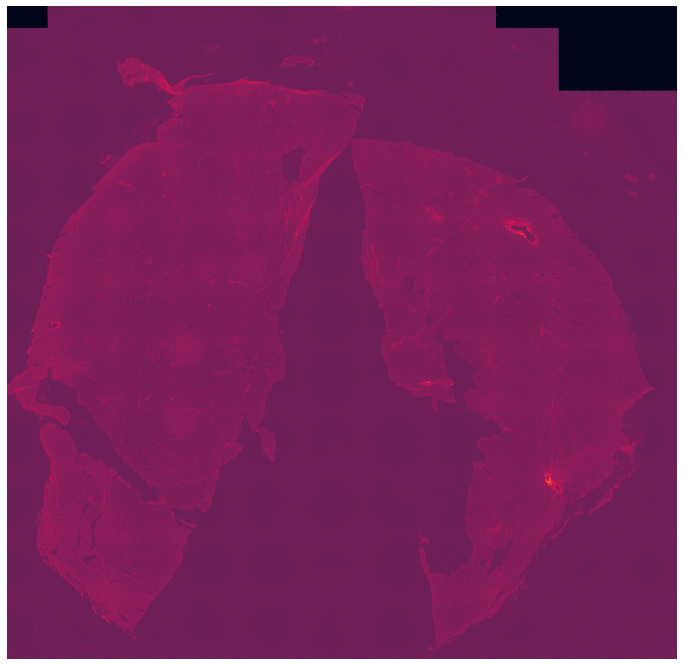

In [5]:
# Step 1
# Load the image
raw_image = load_tiff_image(filename)[1000:20000, 2500:22000]
plt.imshow(raw_image)
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

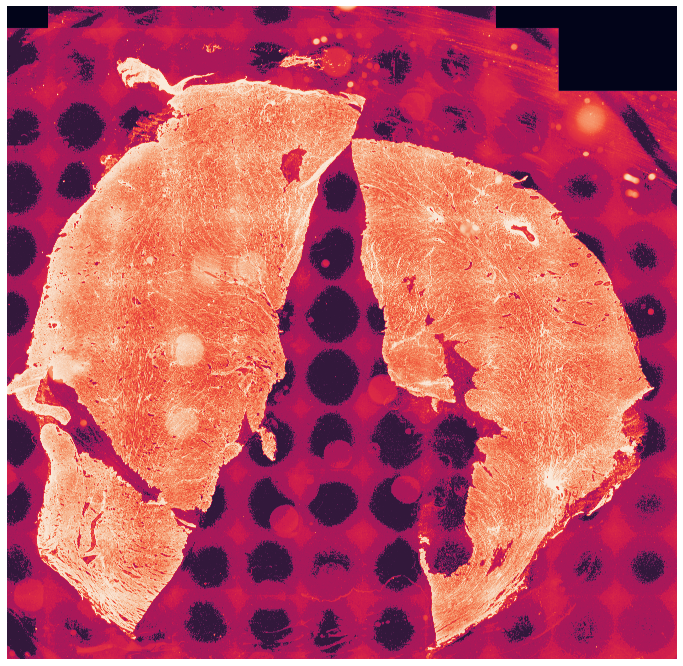

In [6]:
# Equalize the histogram of the loaded image
equalized_lut = equalize_histogram(raw_image)
equalized_image = equalized_lut[raw_image]
plt.imshow(equalized_image)
plt.axis("off")

# Noise Area Detection

(-0.5, 19499.5, 18999.5, -0.5)

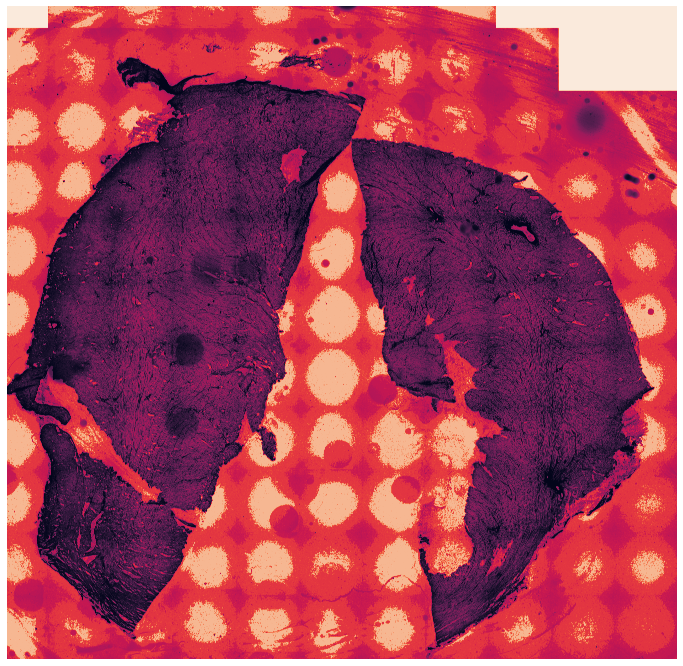

In [7]:
# Inverse the LUT (blacks become whites) in order to highlight noise
inverse_lut = 255 - np.arange(0, 256, 1)
inversed_image = inverse_lut[equalized_image]
plt.imshow(inversed_image)
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

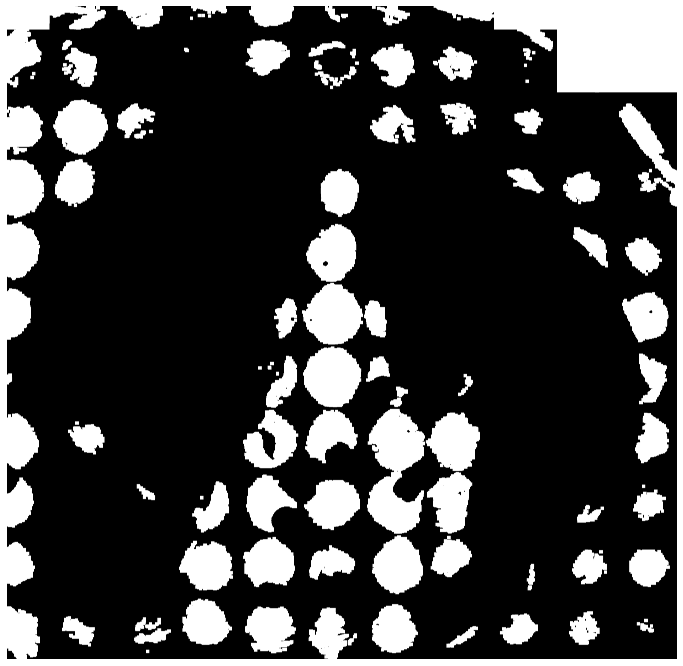

In [8]:
# Emphasize noise areas 
emphasized_image = emphasize_white_areas(
    inversed_image,
    erosion_kernel=np.ones((5, 5), np.uint8),
    dilatation_kernel=np.ones((20, 20), np.uint8),
    n_erosions=3,
    n_dilations=5,
)
plt.imshow(emphasized_image, cmap="gray")
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

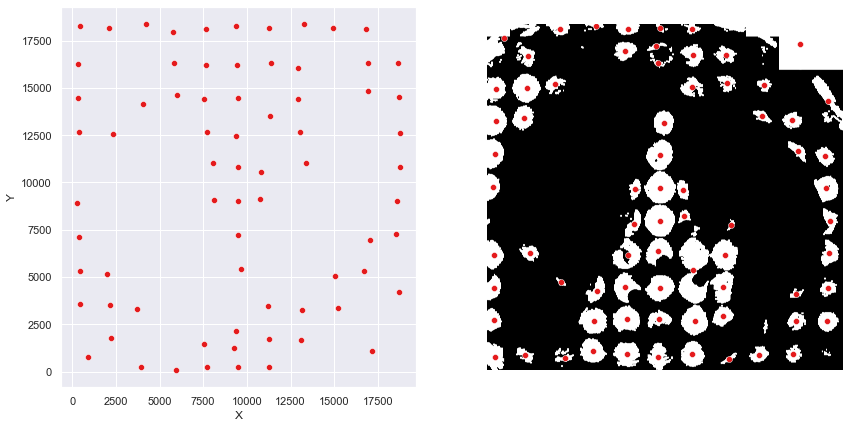

In [9]:
# Detect noise areas' centers
noise_areas_df = detect_noise_areas(emphasized_image)

fig, axes = plt.subplots(1, 2, figsize=(14,7))
sns.scatterplot(ax=axes[0], data=noise_areas_df, x="X", y="Y", color="#e41a1c")
sns.scatterplot(ax=axes[1], data=noise_areas_df, x="X", y="Y", color="#e41a1c")
axes[1].imshow(emphasized_image, cmap="gray")
axes[1].axis("off")

<AxesSubplot:xlabel='X', ylabel='Y'>

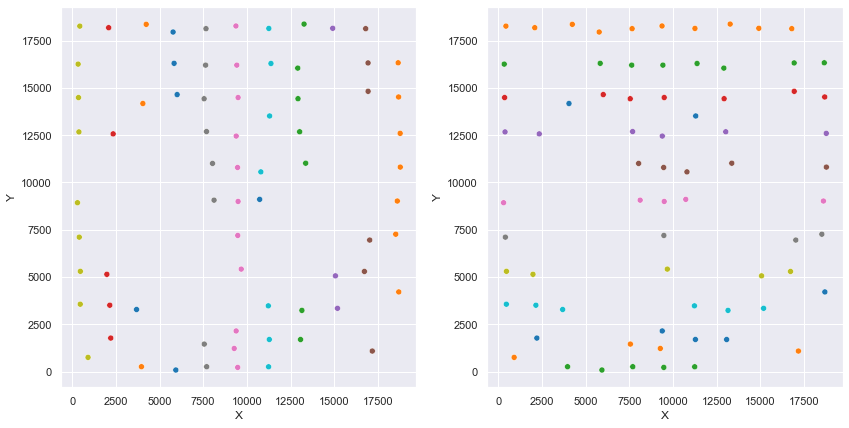

In [10]:
# Step 2 and 3
# Group points that should describe the same vertical and horizontal line
X_groups = get_point_groups(noise_areas_df["X"].to_numpy().reshape(-1, 1))
Y_groups = get_point_groups(noise_areas_df["Y"].to_numpy().reshape(-1, 1))

# Store it in the dataframe
noise_areas_df["X_groups"] = X_groups
noise_areas_df["Y_groups"] = Y_groups
noise_areas_df.sample(5)

fig, axes = plt.subplots(1, 2, figsize=(14,7))
sns.scatterplot(ax=axes[0], data=noise_areas_df, x="X", y="Y", hue="X_groups", palette="tab10", legend=False)
sns.scatterplot(ax=axes[1], data=noise_areas_df, x="X", y="Y", hue="Y_groups", palette="tab10", legend=False)

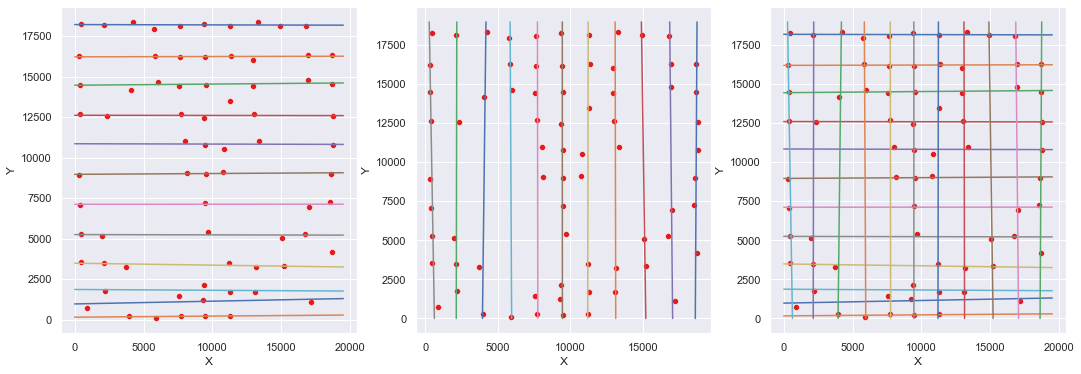

In [11]:
# Step 4
# Interpolate the grid
horizontal_lines = interpolate_lines(noise_areas_df, "X", "Y")
vertical_lines = interpolate_lines(noise_areas_df, "Y", "X")

fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(ax=axes[0], data=noise_areas_df, x="X", y="Y", color="#e41a1c")
sns.scatterplot(ax=axes[1], data=noise_areas_df, x="X", y="Y", color="#e41a1c")
sns.scatterplot(ax=axes[2], data=noise_areas_df, x="X", y="Y", color="#e41a1c")

X1 = np.linspace(0, raw_image.shape[1], 10)
for a, b in horizontal_lines:
    axes[0].plot(X1, a * X1 + b)
    axes[2].plot(X1, a * X1 + b)

X2 = np.linspace(0, raw_image.shape[0], 10)
for a, b in vertical_lines:
    axes[1].plot(a * X2 + b, X2)
    axes[2].plot(a * X2 + b, X2)

(-0.5, 20475.025, 19950.025, -0.5)

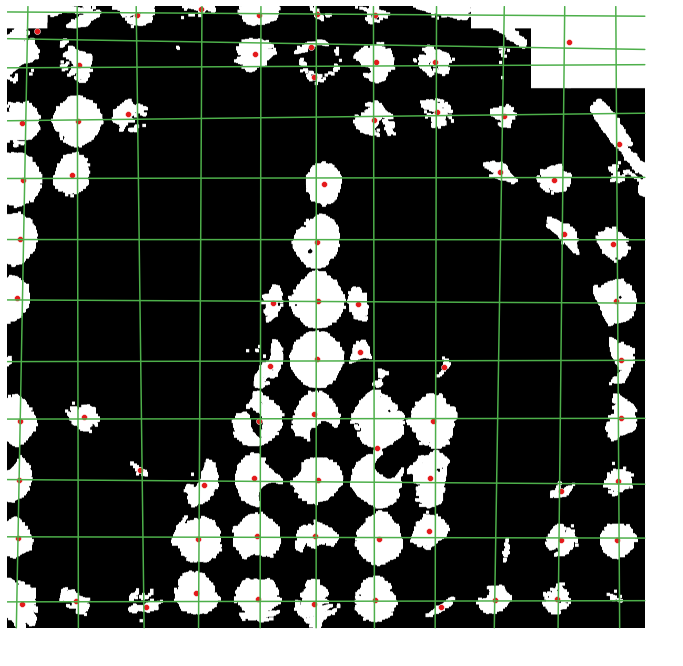

In [12]:
plt.imshow(emphasized_image, cmap="gray")
sns.scatterplot(data=noise_areas_df, x="X", y="Y", color="#e41a1c")

X1 = np.linspace(0, raw_image.shape[1], 10)
for a, b in horizontal_lines:
    plt.plot(X1, a * X1 + b, color="#4daf4a")

X2 = np.linspace(0, raw_image.shape[0], 10)
for a, b in vertical_lines:
    plt.plot(a * X2 + b, X2, color="#4daf4a")
    
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

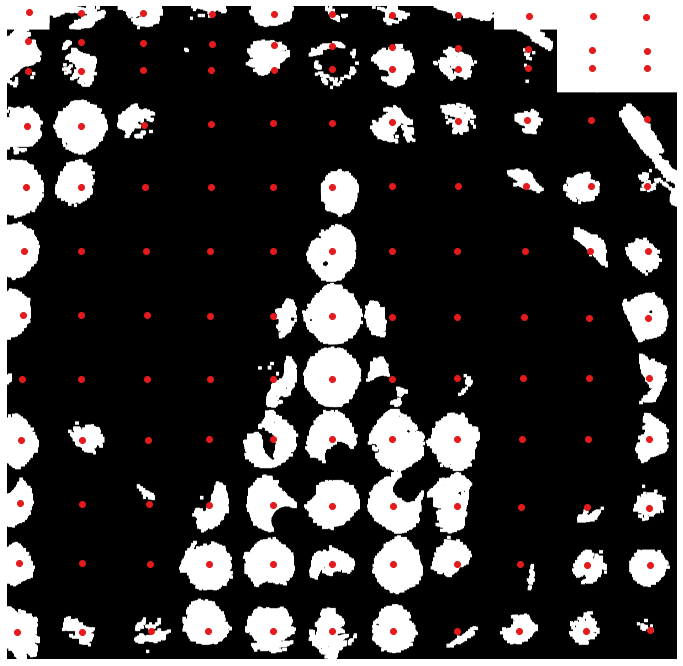

In [13]:
# Step 5
# Find intersection points of the grid
centers_coordinates = get_intersection_points(
    horizontal_lines, vertical_lines
)

X = [coordinate[0] for coordinate in centers_coordinates]
Y = [coordinate[1] for coordinate in centers_coordinates]
plt.imshow(emphasized_image, cmap="gray")
plt.scatter(X, Y, color="#e41a1c")
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

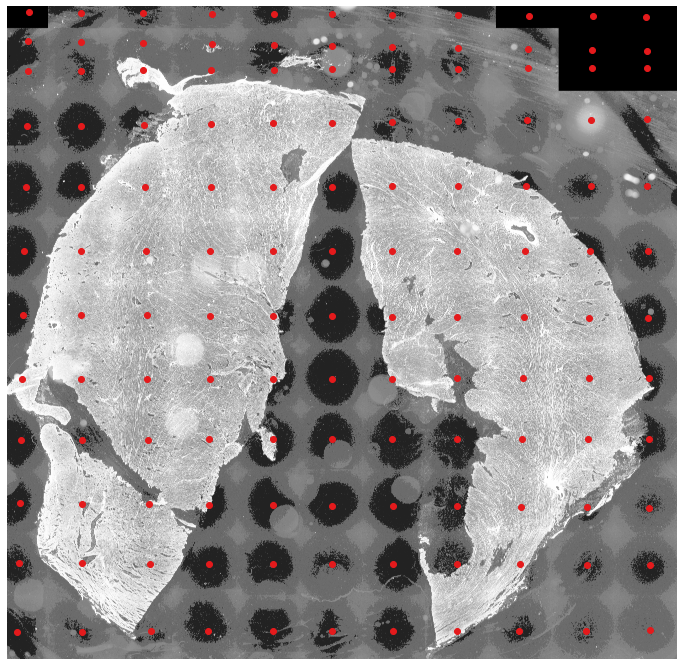

In [14]:
# Run all
centers_coordinates = extract_noise_centers(raw_image)
X = [coordinate[0] for coordinate in centers_coordinates]
Y = [coordinate[1] for coordinate in centers_coordinates]
plt.imshow(equalized_image, cmap="gray")
plt.scatter(X, Y, color="#e41a1c")
plt.axis("off")

# Cell Area Detection

(-0.5, 19499.5, 18999.5, -0.5)

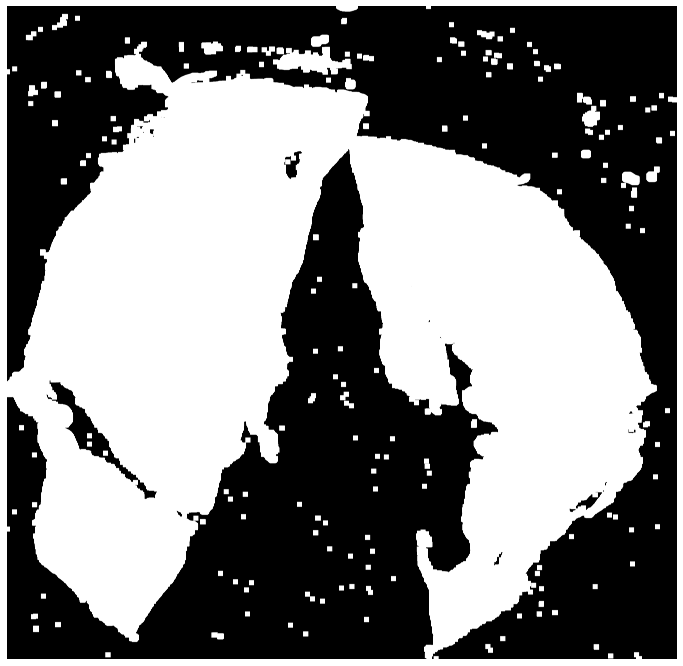

In [15]:
# Emphasize cell areas
emphasized_image = emphasize_white_areas(
    equalized_image,
    erosion_kernel=np.ones((3, 3), np.uint8),
    dilatation_kernel=np.ones((30, 30), np.uint8),
    n_erosions=2,
    n_dilations=5,
)

plt.imshow(emphasized_image, cmap="gray")
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

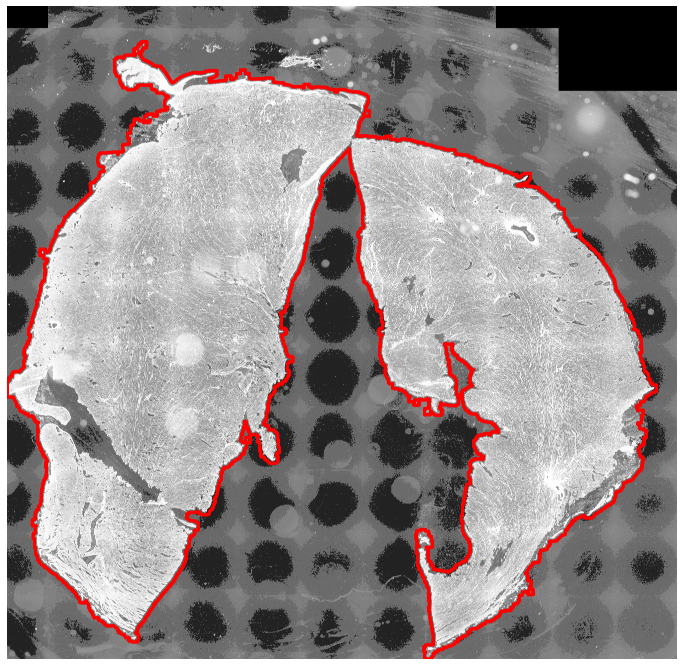

In [16]:
# Find cell's contour
contours, _ = cv2.findContours(
    emphasized_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
)
# Get the largest found contour
cell_contour = max(contours, key=cv2.contourArea)

colored_image = cv2.cvtColor(equalized_image, cv2.COLOR_RGB2BGR)
cv2.drawContours(colored_image, cell_contour, -1, (255,0,0), 100)
plt.imshow(colored_image)
plt.axis("off")

(-0.5, 19499.5, 18999.5, -0.5)

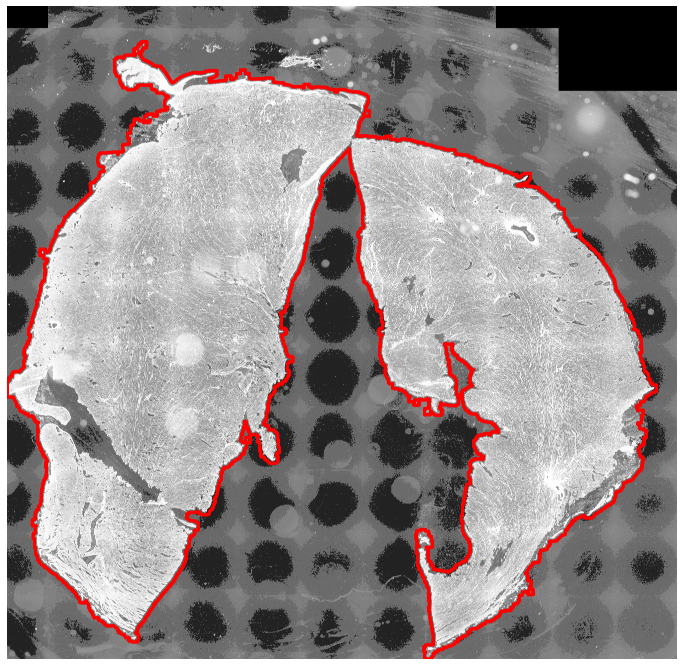

In [17]:
cell_contour = extract_cell_area(raw_image)

colored_image = cv2.cvtColor(equalized_image, cv2.COLOR_RGB2BGR)
cv2.drawContours(colored_image, cell_contour, -1, (255,0,0), 100)
plt.imshow(colored_image)
plt.axis("off")

# Combine Cell and Noise Detection

(-0.5, 19499.5, 18999.5, -0.5)

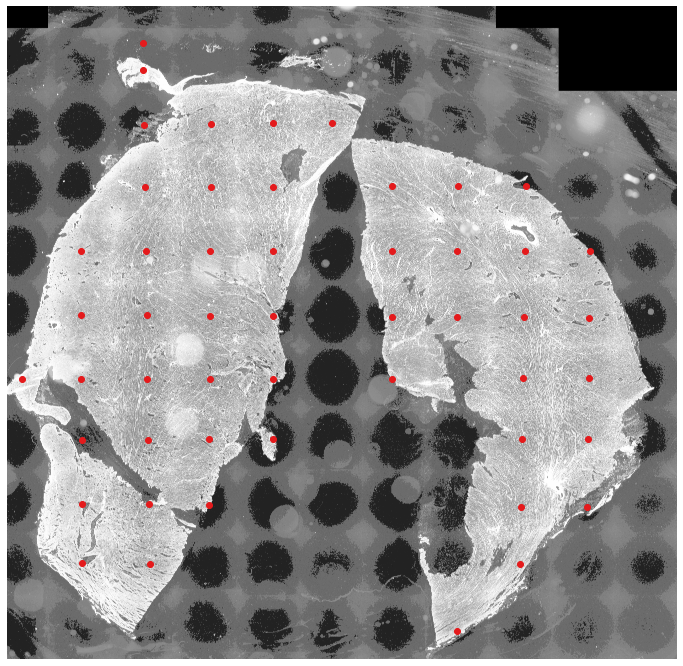

In [18]:
inner_centers = get_inner_centers(centers_coordinates, cell_contour)

X = [coordinate[0] for coordinate in inner_centers]
Y = [coordinate[1] for coordinate in inner_centers]
plt.imshow(equalized_image, cmap="gray")
plt.scatter(X, Y, color="#e41a1c")
plt.axis("off")